In [1]:
from mne.datasets import multimodal
import mne
mne.set_log_level(verbose='CRITICAL')
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg
from deepmeg.training.trainers import Trainer
from deepmeg.data.datasets import read_epochs_dataset, EpochsDataset
from deepmeg.preprocessing.transforms import zscore
from deepmeg.models import BaseModel
import torch
import torch.nn as nn
from collections import defaultdict
from deepmeg.data.utils import make_train_and_val_loaders
from torch.utils.data import DataLoader, Dataset
import torchmetrics
from deepmeg.training.callbacks import PrintingCallback
from deepmeg.models.interpretable import SPIRIT, LFCNN, TimeCompNet
from deepmeg.data.datasets import read_epochs_dataset, EpochsDataset
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch.nn as nn
import torch.nn.init as init
import math
import torch
from deepmeg.convtools import compute_output_shape, conviter

class AutoCov1D(nn.Module):
    def __init__(self, out_channels, window_size, latent_dim = None, overlap=0, stride=1, padding=0, bias=True):
        super().__init__()
        self.window_size = window_size
        self.latent_dim = latent_dim if latent_dim is not None else window_size // 2
        self.overlap = overlap
        self.stride = stride
        self.padding = padding
        self.weight = nn.Parameter(torch.empty(self.window_size, self.latent_dim, out_channels))

        if bias:
            self.bias = nn.Parameter(torch.empty(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self) -> None:
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            if fan_in != 0:
                bound = 1 / math.sqrt(fan_in)
                init.uniform_(self.bias, -bound, bound)

    def forward(self, X):
        # inputs shape (N_batch, width) ~ (N_batch, n_times)
        X_part1 = X[:, :-(self.window_size - self.overlap)] # shape: (batches, times)
        X_part2 = X[:, self.window_size - self.overlap:,]

        assert X_part1.shape == X_part2.shape, f'Windowed sequence is corrupted: {X_part1.shape} vs {X_part2.shape}'

        convargs = ((X_part1.shape[1], X_part1.shape[0]), self.window_size, self.padding, self.stride)
        n_windows = compute_output_shape(*convargs)[0]
        out_tensor = torch.zeros(X.shape[0], n_windows, self.weight.shape[-1]) # ~ batches x n_windows x out_channels

        # iter over neurons
        for n_neuron in range(self.weight.shape[-1]):
            for p, q, k in conviter(*convargs):
                # p shape: n_times, ...
                # q shape: n_windows, 0
                # k shape: window_size, ...
                time_range = p[0]
                window_range = k[0]
                n_window = q[0]

                window1 = X_part1[:, time_range]
                window2 = X_part2[:, time_range]
                weight = self.weight[window_range, :, n_neuron]

                proj1 = torch.matmul(window1, weight) # (N batch x time_range) @ (window_range x latent_dim x n_neuron) = (N batch x latent_dim)
                proj2 = torch.matmul(window2, weight)
                cov = torch.mean(
                    (proj1 - torch.mean(proj1, 1, keepdim=True))*
                    (proj2 - torch.mean(proj2, 1, keepdim=True)),
                    1,
                    keepdim=True
                ) # ~ (N_batch, 1)
                out_tensor[:, n_window, n_neuron] = torch.squeeze(cov, -1) + self.bias[n_neuron] if self.bias is not None else torch.squeeze(cov, -1)

        return out_tensor

In [3]:
import torch.nn as nn
import torch.nn.init as init
import math
import torch

import torch.nn as nn
import torch.nn.init as init
import math
import torch

class Fourier(nn.Module):
    def __init__(self, n_points, n_components):
        super().__init__()
        self.n_points = n_points
        self.n_components = n_components
        self.a = nn.Parameter(torch.empty(self.n_points, self.n_components, 1))
        self.b = nn.Parameter(torch.empty(self.n_points, self.n_components, 1))

        self.a0 = nn.Parameter(torch.empty(1))


        self.reset_parameters()

    def reset_parameters(self) -> None:
        init.uniform_(self.a, -0.01, 0.01)
        init.uniform_(self.b, -0.01, 0.01)
        init.uniform_(self.a0, -0.01, 0.01)

    def forward(self, x):
        out = self.a0/(2*self.n_points)*torch.ones_like(x)
        for n in range(self.n_components):
            out += (x@self.a[:, n])*torch.cos((2*np.pi*x*n)/self.n_points) + (x@self.b[:, n])*torch.sin((2*np.pi*x*n)/self.n_points)

        return out


class FourierNet(BaseModel):

    def __init__(self, n_points, n_components=None):
        super().__init__()

        if n_components is None:
            n_components = n_points//2

        self.layer = Fourier(n_points, n_components)
        self.bn = nn.BatchNorm1d(n_points)

    def forward(self, x):
        x = self.bn(x)
        x = self.layer(x)
        return x

from deepmeg.convtools import compute_output_shape, conviter

class AutoCov1D(nn.Module):
    def __init__(self, out_channels, window_size, latent_dim = None, overlap=0, stride=1, padding=0, bias=True):
        super().__init__()
        self.window_size = window_size
        self.latent_dim = latent_dim if latent_dim is not None else window_size // 2
        self.overlap = overlap
        self.stride = stride
        self.padding = padding
        # self.weight = nn.Parameter(torch.empty(self.window_size, self.latent_dim, out_channels))
        self.transform = nn.ModuleList([FourierNet(self.window_size) for _ in range(out_channels)])
        self.transform2 = nn.ModuleList([FourierNet(self.window_size) for _ in range(out_channels)])

        if bias:
            self.bias = nn.Parameter(torch.empty(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self) -> None:
        # init.uniform_(self.weight, -0.01, 0.01)
        if self.bias is not None:
            init.uniform_(self.bias, -0.01, 0.01)

    def forward(self, X):
        # inputs shape (N_batch, width) ~ (N_batch, n_times)
        X_part1 = X[:, :-(self.window_size - self.overlap)] # shape: (batches, times)
        X_part2 = X[:, self.window_size - self.overlap:,]

        assert X_part1.shape == X_part2.shape, f'Windowed sequence is corrupted: {X_part1.shape} vs {X_part2.shape}'

        convargs = ((X_part1.shape[1], X_part1.shape[0]), self.window_size, self.padding, self.stride)
        n_windows = compute_output_shape(*convargs)[0]
        out_tensor = torch.zeros(X.shape[0], n_windows, len(self.transform)) # ~ batches x n_windows x out_channels

        # iter over neurons
        for n_neuron in range(len(self.transform)):
            for p, q, k in conviter(*convargs):
                # p shape: n_times, ...
                # q shape: n_windows, 0
                # k shape: window_size, ...
                pad_params = list()

                time_range = p[0]
                window_range = k[0]
                n_window = q[0]

                if window_range.start is not None and abs(window_range.start) < self.window_size:
                    pad_params.append(abs(window_range.start))
                else:
                    pad_params.append(0)
                if window_range.stop is not None and abs(window_range.stop) < self.window_size:
                    pad_params.append(abs(window_range.stop))
                else:
                    pad_params.append(0)

                window1 = X_part1[:, time_range]
                window2 = X_part2[:, time_range]

                if pad_params != [0, 0]:
                    window1 = nn.functional.pad(window1, pad_params)
                    window2 = nn.functional.pad(window2, pad_params)

                # weight = self.weight[window_range, :, n_neuron]

                # proj1 = torch.matmul(window1, weight) # (N batch x time_range) @ (window_range x latent_dim x n_neuron) = (N batch x latent_dim)
                # proj2 = torch.matmul(window2, weight)
                proj1 = self.transform[n_neuron](window1)
                proj2 = self.transform2[n_neuron](window2)

                cov = torch.mean(
                    (proj1 - torch.mean(proj1, 1, keepdim=True))*
                    (proj2 - torch.mean(proj2, 1, keepdim=True)),
                    1,
                    keepdim=True
                ) # ~ (N_batch, 1)
                out_tensor[:, n_window, n_neuron] = torch.squeeze(cov, -1) + self.bias[n_neuron] if self.bias is not None else torch.squeeze(cov, -1)

        return out_tensor

# X = torch.rand(100, 204)
# AutoCov1D(1, 20, 20, 0, 20, 10)(X)


class SPIRIT(BaseModel):
    def __init__(
        self,
        n_channels: int,
        n_latent: int,
        n_times: int,
        filter_size: int,
        window_size: int,
        latent_dim: int,
        pool_factor: int,
        n_outputs: int
    ):
        super().__init__()
        self.unmixing_layer = nn.Conv1d(n_channels, n_latent, kernel_size=1, bias=True)
        self.temp_conv = nn.Conv1d(n_latent, n_latent, kernel_size=filter_size, bias=True, groups=n_latent, padding='same')
        self.timesel_list = nn.ModuleList([
            nn.Sequential(
                AutoCov1D(1, window_size, latent_dim, 0, window_size, bias=True),
            )
            for _ in range(n_latent)
        ])
        self.expander = nn.Conv1d(
            in_channels=8,
            out_channels=8,
            kernel_size=(2,),
            padding=1
        )
        self.windows = [win for win, _, _ in conviter((n_times-(window_size),), window_size, 0, window_size)]
        self.windows.append(slice(self.windows[-1].start + window_size, None))
        self.timecomp_list = nn.ModuleList([
            nn.Sequential(
                nn.Linear(
                    n_times,
                    (n_times//pool_factor),
                    bias=False
                ),
                nn.Dropout(.25),
                torch.nn.Sigmoid()
            )
            for i in range(n_latent)
        ])
        final_out_features = (n_times//pool_factor)*n_latent
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x: torch.Tensor):
        x = self.unmixing_layer(x)
        x = self.temp_conv(x)
        x_est = torch.stack(
            [
                timesel(x[:, i, :]) for i, timesel in enumerate(self.timesel_list)
            ],
            1
        )

        x_est = torch.squeeze(x_est, -1)
        x_est = self.expander(x_est)

        x_out = list()
        for i, window in enumerate(self.windows):
            x_out.append(
                x[:, :, window]
                *torch.unsqueeze(x_est[:, :, i], -1)
            )

        x = torch.cat(x_out, -1)

        x = torch.stack(
            [
                timesel(x[:, i, :]) for i, timesel in enumerate(self.timecomp_list)
            ],
            1
        )
        x = torch.flatten(x, 1)
        return self.fc_layer(x)


# SPIRIT(
#     **model_kwargs
# )(X)

In [4]:
# very simple function to plot history of the model training

def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()

In [5]:
fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)

cond = raw.acqparser.get_condition(raw, None)

# for c in cond:
#     c['tmin'] = -.5
#     c['tmax'] = 1.

# get the list of condition names
condition_names = [k for c in cond for k,v in c['event_id'].items()]
epochs_list = [mne.Epochs(raw, **c) for c in cond]
epochs = mne.concatenate_epochs(epochs_list)
epochs.pick_types(meg='grad')
epochs_original = epochs.copy()


In [6]:
epochs = epochs_original.copy()
epochs.apply_baseline((None, 0.))
epochs.crop(.0, None)

Number of events,940
Events,Auditory left: 117Auditory right: 104Somato left: 118Somato right: 107Visual Lower left: 115Visual Lower right: 129Visual Upper left: 133Visual Upper right: 117
Time range,0.000 – 0.499 sec
Baseline,-0.100 – 0.000 sec


In [21]:
data = epochs.get_data().copy()
labels = epochs.events[:, 2]

In [22]:
data += 2*5e-11*np.random.random(data.shape) - 5e-11

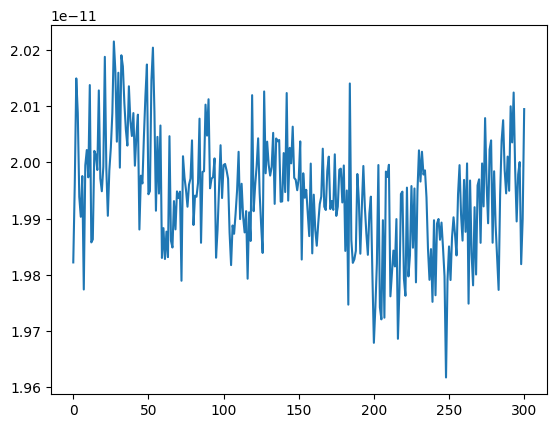

In [23]:
plt.plot(data.mean((0, 1)))

In [12]:
data.min(), data.max()

(-3.3504387284969226e-10, 5.801460444220668e-10)

In [24]:
from deepmeg.preprocessing.transforms import one_hot_encoder
dataset = EpochsDataset(
    (
        # epochsoi
        data,
        one_hot_encoder(labels)
    ),
    savepath='../datasets/multimodal_noisy',
    transform=zscore
)
train, test = torch.utils.data.random_split(dataset, [.7, .3])

In [25]:
dataset.save('../data/multimodal_noisy.pt')

In [4]:
dataset = read_epochs_dataset('../data/multimodal_noisy.pt')
train, test = torch.utils.data.random_split(dataset, [.7, .3])

In [27]:
X, y = next(iter(DataLoader(train, 2)))

In [32]:
model_kwargs = dict(
    n_channels=204,
    n_latent=8,
    n_times=X.shape[-1],
    filter_size=50,
    window_size=10,
    latent_dim=10,
    pool_factor=10,
    n_outputs=8
)

In [33]:
model = SPIRIT(
    **model_kwargs
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight', 'temp_conv.weight',
                # *[f'timesel_list.{i}.0.transform.0.layer.a' for i in range(8)],
                # *[f'timesel_list.{i}.0.transform.0.layer.b' for i in range(8)],
                # *[f'timecomp_list.{i}.0.weight' for i in range(8)],
            ], lambdas=[
                .01, .01,
                # *[.01 for _ in range(8)],
                # *[.01 for _ in range(8)],
                # *[.01 for _ in range(8)]
            ]
            # lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

Epoch 0:  loss_train:  0.7015   |    binary_accuracy_train:  0.5922   |    loss_val:  0.6233   |    binary_accuracy_val:  0.8750
Epoch 1:  loss_train:  0.5886   |    binary_accuracy_train:  0.8750   |    loss_val:  0.5329   |    binary_accuracy_val:  0.8750
Epoch 2:  loss_train:  0.5085   |    binary_accuracy_train:  0.8750   |    loss_val:  0.4729   |    binary_accuracy_val:  0.8750
Epoch 3:  loss_train:  0.4571   |    binary_accuracy_train:  0.8750   |    loss_val:  0.4375   |    binary_accuracy_val:  0.8750
Epoch 4:  loss_train:  0.4279   |    binary_accuracy_train:  0.8750   |    loss_val:  0.4199   |    binary_accuracy_val:  0.8750
Epoch 5:  loss_train:  0.4140   |    binary_accuracy_train:  0.8750   |    loss_val:  0.4135   |    binary_accuracy_val:  0.8750
Epoch 6:  loss_train:  0.4096   |    binary_accuracy_train:  0.8750   |    loss_val:  0.4133   |    binary_accuracy_val:  0.8750
Epoch 7:  loss_train:  0.4099   |    binary_accuracy_train:  0.8750   |    loss_val:  0.4159   | 

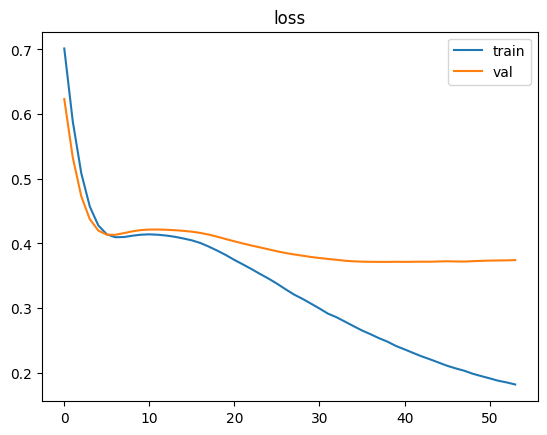

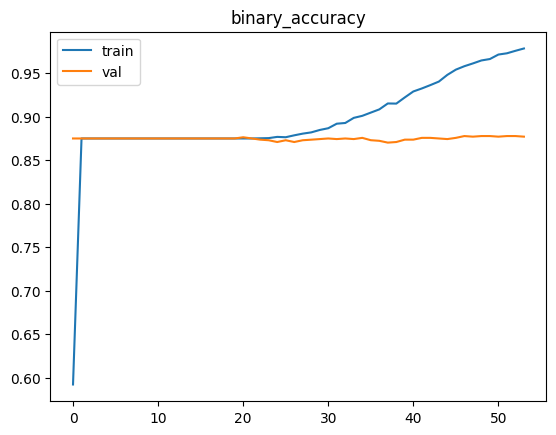

In [34]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [35]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.2560381049459631
train_binary_accuracy: 0.9341783198443326
loss: 0.36452859369191254
binary_accuracy: 0.875


In [36]:
from mne.datasets import multimodal
fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')

info = mne.io.read_raw_fif(fname_raw).pick_types(meg='grad').info

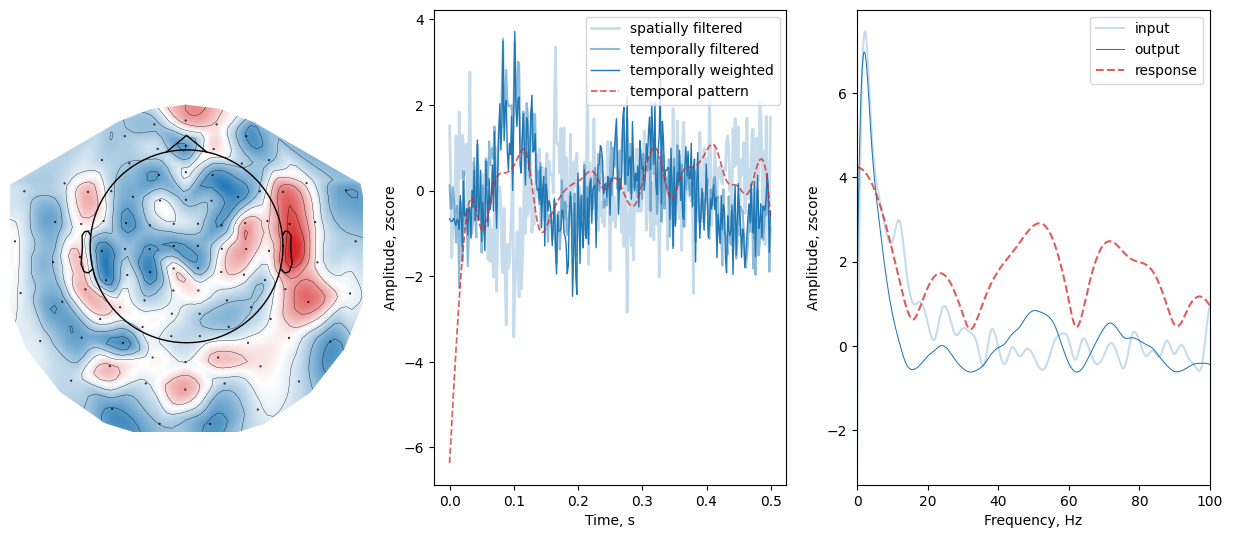

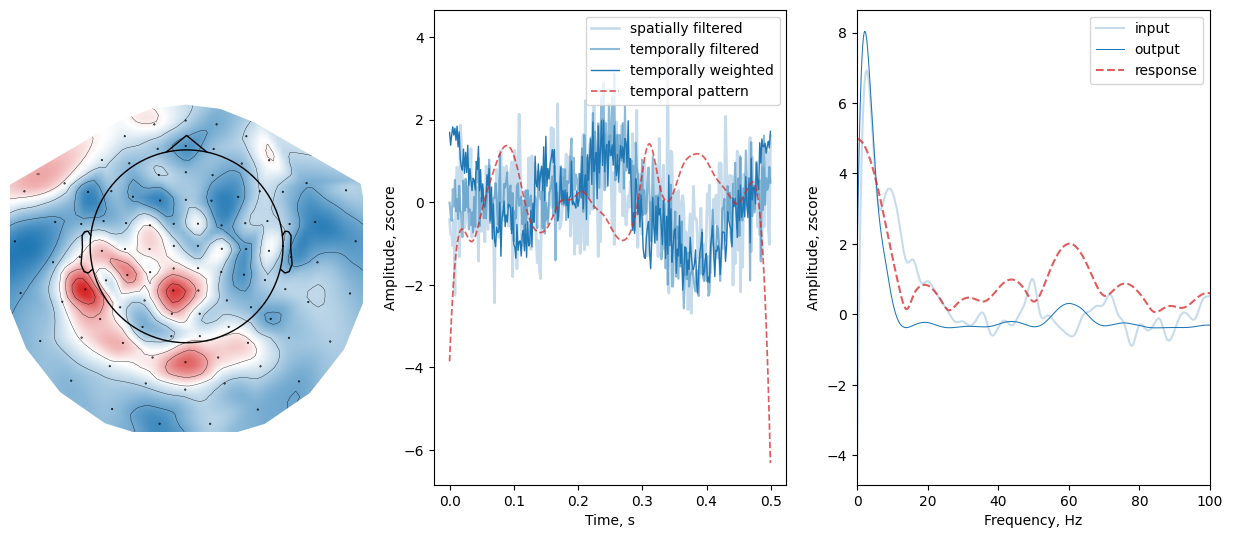

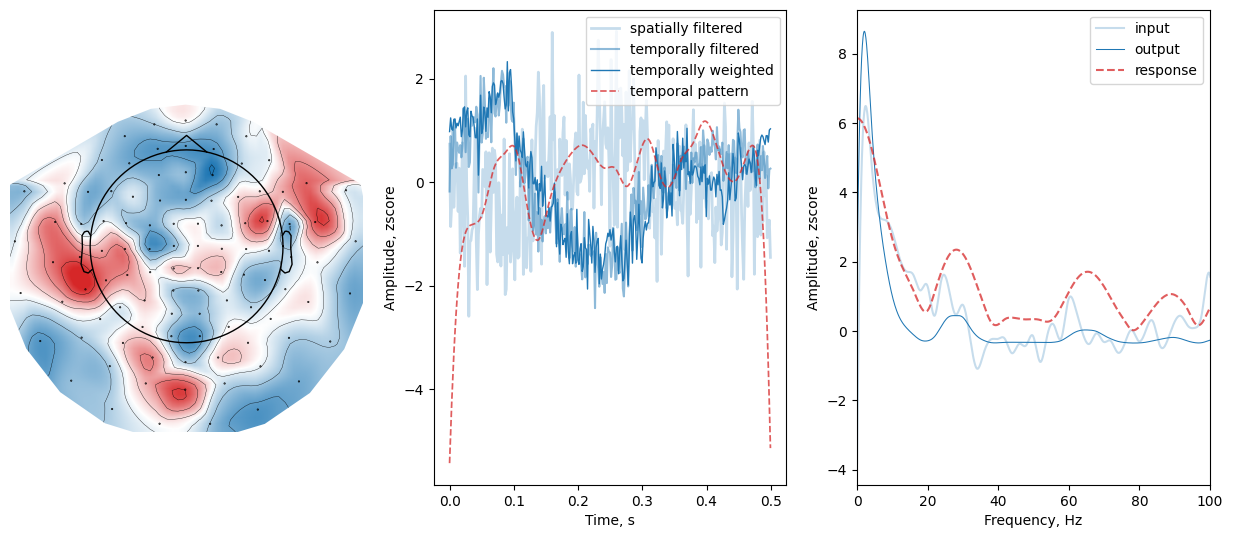

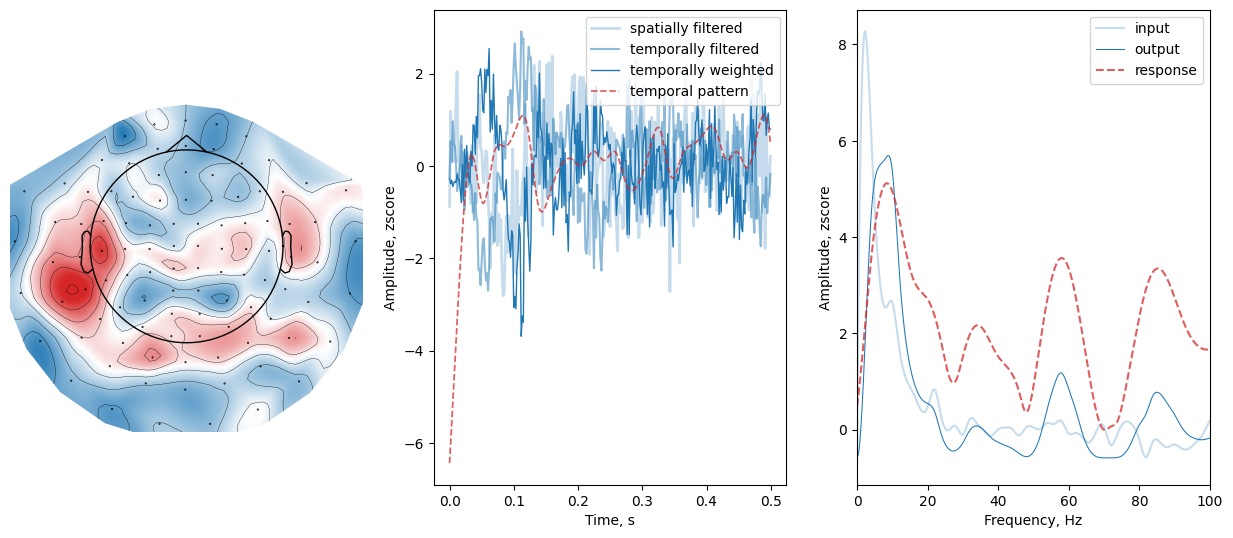

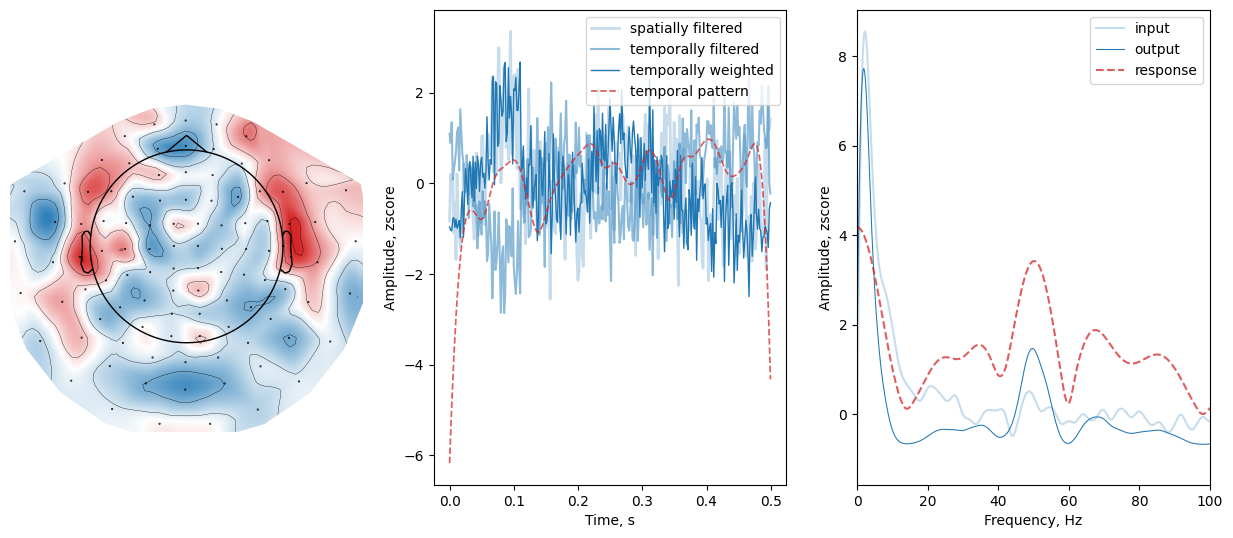

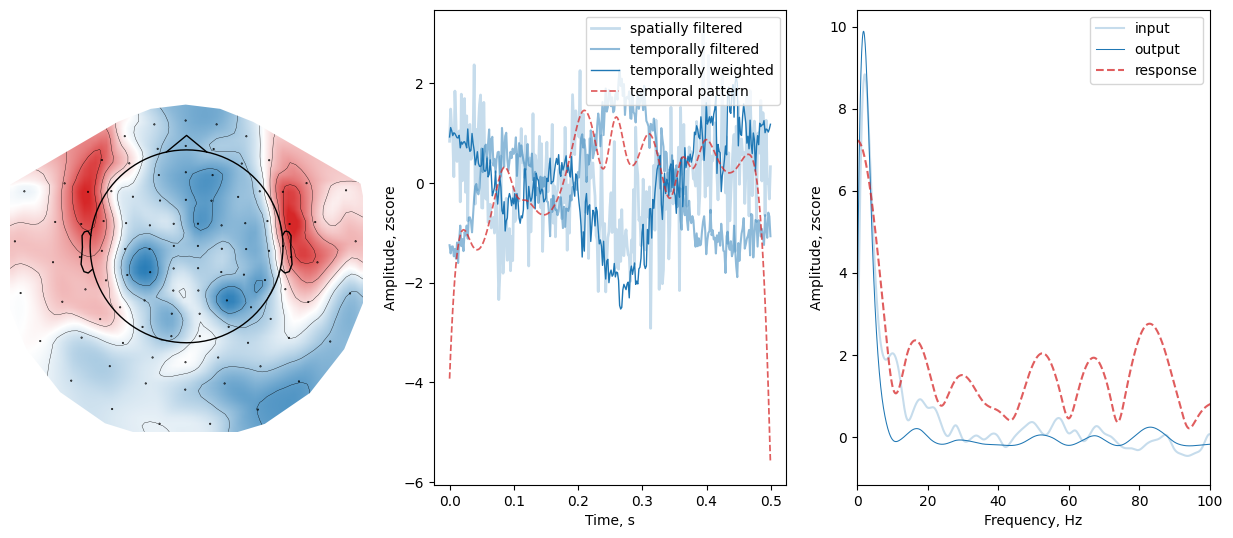

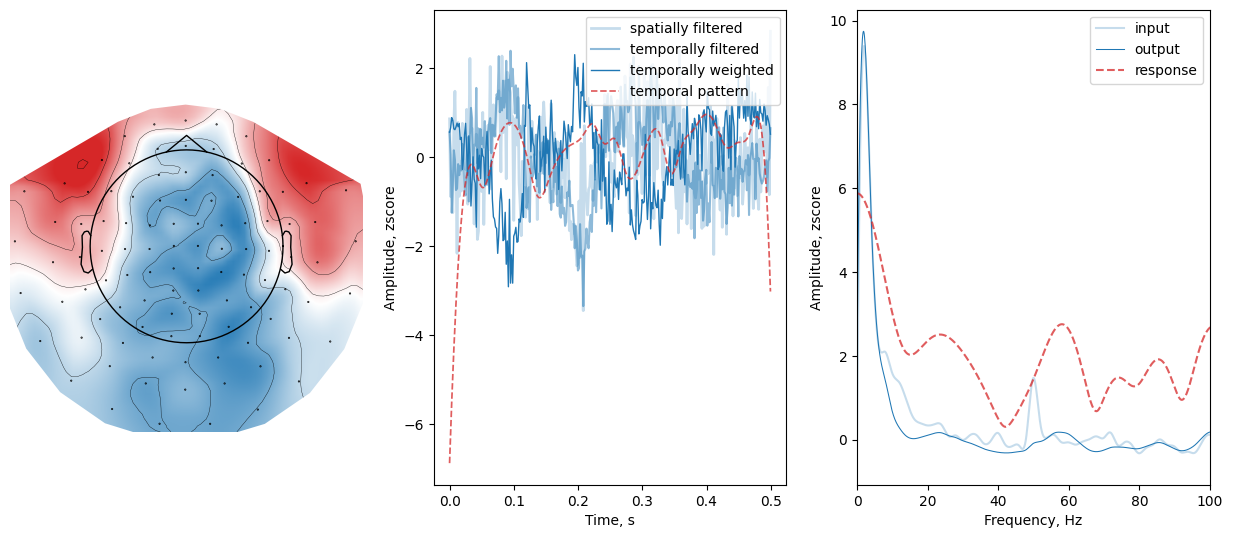

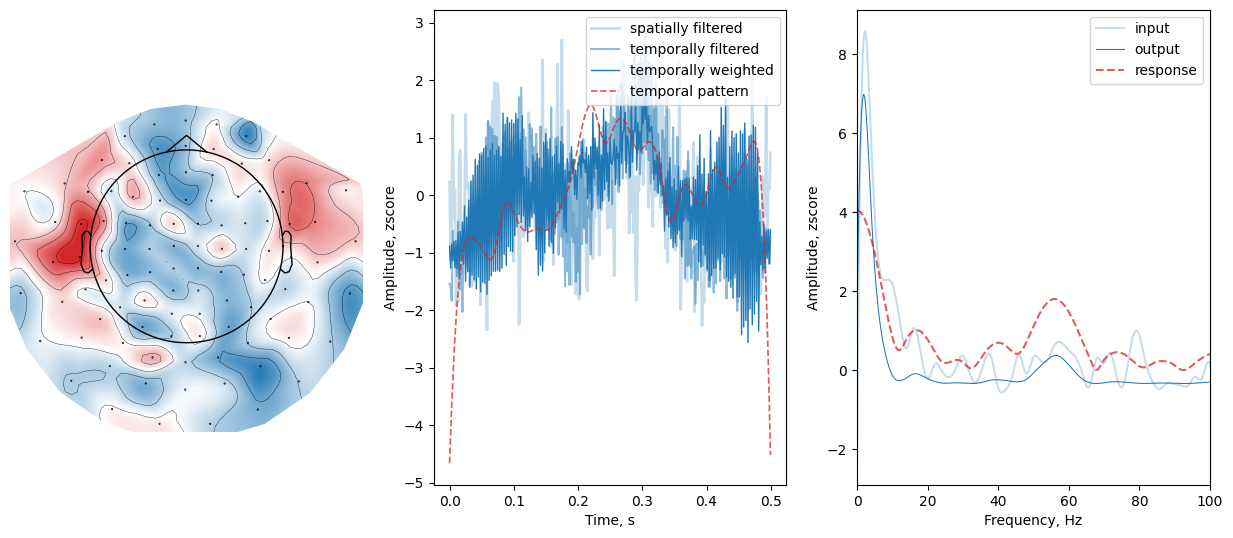

In [37]:
from deepmeg.interpreters import SPIRITInterpreter

interpreter = SPIRITInterpreter(model, test, info)
for branch in range(8):
    fig = interpreter.plot_branch(branch)
    plt.show()

In [28]:
model_kwargs = {
    'n_channels': 204,
    'n_latent': 8,
    'n_times': X.shape[-1],
    'filter_size': 50,
    'pool_factor': 10,
    'n_outputs': 8
}

In [29]:
# from deepmeg.models.interpretable import LFCNN

model = LFCNN(
    **model_kwargs
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                'unmixing_layer.weight', 'temp_conv.weight',
            ], lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

  0%|          | 0/150 [00:00<?, ?it/s]

/home/user/Projects/deepmeg/venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch 0:  loss_train:  0.7282   |    binary_accuracy_train:  0.5022   |    loss_val:  0.7155   |    binary_accuracy_val:  0.5660
Epoch 1:  loss_train:  0.7022   |    binary_accuracy_train:  0.6153   |    loss_val:  0.6942   |    binary_accuracy_val:  0.6628
Epoch 2:  loss_train:  0.6761   |    binary_accuracy_train:  0.7111   |    loss_val:  0.6713   |    binary_accuracy_val:  0.7349
Epoch 3:  loss_train:  0.6480   |    binary_accuracy_train:  0.7937   |    loss_val:  0.6459   |    binary_accuracy_val:  0.7933
Epoch 4:  loss_train:  0.6172   |    binary_accuracy_train:  0.8368   |    loss_val:  0.6180   |    binary_accuracy_val:  0.8270
Epoch 5:  loss_train:  0.5838   |    binary_accuracy_train:  0.8577   |    loss_val:  0.5880   |    binary_accuracy_val:  0.8393
Epoch 6:  loss_train:  0.5487   |    binary_accuracy_train:  0.8657   |    loss_val:  0.5566   |    binary_accuracy_val:  0.8524
Epoch 7:  loss_train:  0.5135   |    binary_accuracy_train:  0.8698   |    loss_val:  0.5253   | 

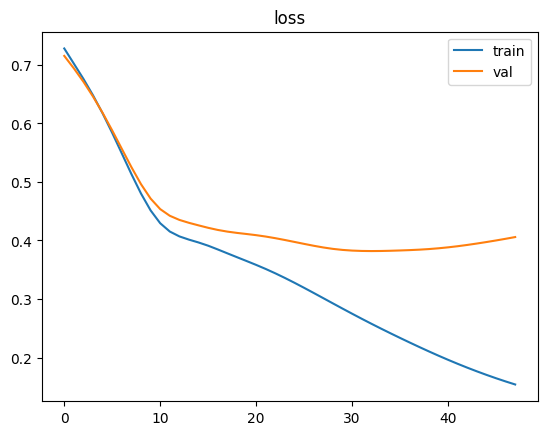

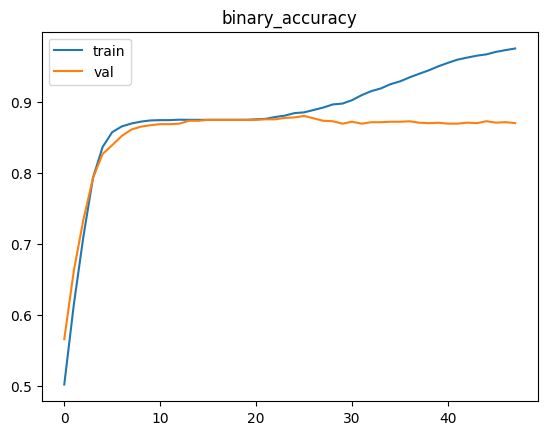

In [30]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

In [31]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.2866904681379145
train_binary_accuracy: 0.9042395136573098
loss: 0.38515166531909595
binary_accuracy: 0.8733766187321056
